# Faulty Takata Airbags using Decision Trees

**The story:**
- https://www.nytimes.com/2014/09/12/business/air-bag-flaw-long-known-led-to-recalls.html
- https://www.nytimes.com/2014/11/07/business/airbag-maker-takata-is-said-to-have-conducted-secret-tests.html
- https://www.nytimes.com/interactive/2015/06/22/business/international/takata-airbag-recall-list.html
- https://www.nytimes.com/2016/08/27/business/takata-airbag-recall-crisis.html

This story, done by The New York Times, investigates the content in complaints made to National Highway Traffic Safety Administration (NHTSA) by customers who had bad experiences with Takata airbags in their cars. Eventually, car companies had to recall airbags made by the airbag supplier that promised a cheaper alternative. 

**Author:** Daeil Kim did a more complex version of this particular analysis - [presentation here](https://www.slideshare.net/mortardata/daeil-kim-at-the-nyc-data-science-meetup)

**Topics:** Decision Trees, Random Forests

**Datasets**

* **sampled-labeled.csv:** a sample of vehicle complaints, labeled with being suspicious or not

## What's the goal?

It was too much work to read twenty years of vehicle comments to find the ones related to dangerous airbags! Because we're lazy, we wanted the computer to do this for us. We did this before with a classifier that used logistic regression, now we're going to try a different one.

<p class="reading-options">
  <a class="btn" href="/nyt-takata-airbags/nyt-takata-decision-tree-completed">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/nyt-takata-airbags/notebooks/NYT Takata (Decision Tree) (Completed).ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/nyt-takata-airbags/notebooks/NYT Takata (Decision Tree) (Completed).ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **sampled-labeled.csv:** labeled complaints - a sample of vehicle complaints, labeled with being suspicious or not


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/nyt-takata-airbags/data/sampled-labeled.csv -P data

# Our code

## Setup

In [1]:
import pandas as pd

# Allow us to display 100 columns at a time, and 100 characters in each column (instead of ...)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 100)

## Read in our labeled data

We aren't going to be using the unlabeled dataset this time, we're only going to look at **how our classifier works.** We'll start by reading in our complaints that have labeled attached to them.

**Read in `sampled-labeled.csv` and check how many suspicious/not suspicious complaints we have.**

In [2]:
labeled = pd.read_csv("data/sampled-labeled.csv")
labeled.head()

,is_suspicious,CDESCR
0,0.0,"ALTHOUGH I LOVED THE CAR OVERALL AT THE TIME I DECIDED TO OWN, , MY DREAM CAR CADILLAC CTS HAS T..."
1,0.0,"CONSUMER SHUT SLIDING DOOR WHEN ALL POWER LOCKS ON ALL DOORS LOCKED BY ITSELF, TRAPPING INFANT I..."
2,0.0,DRIVERS SEAT BACK COLLAPSED AND BENT WHEN REAR ENDED. PLEASE DESCRIBE DETAILS. TT
3,0.0,TL* THE CONTACT OWNS A 2009 NISSAN ALTIMA. THE CONTACT STATED THAT THE START BUTTON FOR THE IGNI...
4,0.0,THE FRONT MIDDLE SEAT DOESN'T LOCK IN PLACE. *AK


In [3]:
labeled.is_suspicious.value_counts()

0.0    150
1.0     15
Name: is_suspicious, dtype: int64

150 non-suspicious and 15 suspicious is a pretty terrible ratio, but we're remarkably lazy and not very many of the comments are actually suspicious.

Now that we've read a few, let's train our classifier

## Creating features

### Selecting our features and building a features dataframe

Last time, we can thought of some words or phrases that might make a comment interesting or not interesting. We came up with this list:

* airbag
* air bag
* failed
* did not deploy
* violent
* explode
* shrapnel

These **features** are the things that the machine learning algorithm is going to look for when it's reading. There are lots of words in each complaint, but these are the only ones we'll tell the classifier to pay attention to!

To determine if a word is in `CDESCR`, we can use `.str.contains`. Because computers only like numbers, though, we need to use `.astype(int)` to change it from `True`/`False` to `1`/`0`. 

In [4]:
train_df = pd.DataFrame({
    'is_suspicious': labeled.is_suspicious,
    'airbag': labeled.CDESCR.str.contains("AIRBAG", na=False).astype(int),
    'air bag': labeled.CDESCR.str.contains("AIR BAG", na=False).astype(int),
    'failed': labeled.CDESCR.str.contains("FAILED", na=False).astype(int),
    'did not deploy': labeled.CDESCR.str.contains("DID NOT DEPLOY", na=False).astype(int),
    'violent': labeled.CDESCR.str.contains("VIOLENT", na=False).astype(int),
    'explode': labeled.CDESCR.str.contains("EXPLODE", na=False).astype(int),
    'shrapnel': labeled.CDESCR.str.contains("SHRAPNEL", na=False).astype(int),
})
train_df.head()

,is_suspicious,airbag,air bag,failed,did not deploy,violent,explode,shrapnel
0,0.0,0,0,0,0,0,0,0
1,0.0,0,0,0,0,0,0,0
2,0.0,0,0,0,0,0,0,0
3,0.0,0,0,0,0,0,0,0
4,0.0,0,0,0,0,0,0,0


Let's see how big our dataset is, and then remove any rows that are missing data (not all of them are labeled).

In [5]:
train_df.shape

(350, 8)

In [6]:
train_df = train_df.dropna()
train_df.shape

(165, 8)

## Creating our classifier

Any time you're bulding a classifier, doing regression, or most anything with machine learning, you're using a **model**. It **models** the relationship between the inputs and the outputs.

### Classification with Decision Trees

Last time we used a classifier based on **Logistic Regression**. First we split into `X` (our features) and `y` (our labels), and trained the classifier on them.

In [7]:
from sklearn.linear_model import LogisticRegression

X = train_df.drop(columns='is_suspicious')
y = train_df.is_suspicious

clf = LogisticRegression(C=1e9, solver='lbfgs')

clf.fit(X, y)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

After we built our classifier, we tested it and found it didn't work very well.

In [8]:
from sklearn.metrics import confusion_matrix

y_true = y
y_pred = clf.predict(X)

matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['not suspicious', 'suspicious'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names)

,Predicted not suspicious,Predicted suspicious
Is not suspicious,150,0
Is suspicious,13,2


To understand a logisic regression classifier, we looked at the coefficients and the odds ratios.

In [9]:
import numpy as np

feature_names = X.columns
coefficients = clf.coef_[0]

pd.DataFrame({
    'feature': feature_names,
    'coefficient (log odds ratio)': coefficients,
    'odds ratio': np.exp(coefficients).round(4)
}).sort_values(by='odds ratio', ascending=False)

,feature,coefficient (log odds ratio),odds ratio
4,violent,41.423096,9.768364e+17
5,explode,1.269048,3.557500e+00
1,air bag,1.268123,3.554200e+00
0,airbag,0.945612,2.574400e+00
2,failed,-27.175214,0.000000e+00
3,did not deploy,-37.906428,0.000000e+00
6,shrapnel,-13.204894,0.000000e+00


### Classification with Decision Trees

We can also use a classifier called a **decision tree**. All you need to do is have one new import and change the line where you create your classifier.

In [10]:
#from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

X = train_df.drop(columns='is_suspicious')
y = train_df.is_suspicious

#clf = LogisticRegression(C=1e9, solver='lbfgs')
clf = DecisionTreeClassifier()

clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Confusion matrix code looks exactly the same.

In [11]:
from sklearn.metrics import confusion_matrix

y_true = y
y_pred = clf.predict(X)

matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['not suspicious', 'suspicious'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names)

,Predicted not suspicious,Predicted suspicious
Is not suspicious,150,0
Is suspicious,13,2


When using a decision tree, **using the classifier is the same, but the code to understand the classifier is a bit different.** Instead of coefficients, we're going to look at **feature importance.**

In [12]:
import eli5

label_names = ['not suspicious', 'suspicious']
feature_names = list(X.columns)

eli5.show_weights(clf,
                  feature_names=feature_names,
                  target_names=label_names,
                  show=['feature_importances', 'description'])

Weight,Feature
0.3440,airbag
0.2026,violent
0.1529,air bag
0.1445,explode
0.1205,did not deploy
0.0266,failed
0.0091,shrapnel


The most fun part of using a decision tree is **visualizing it.**

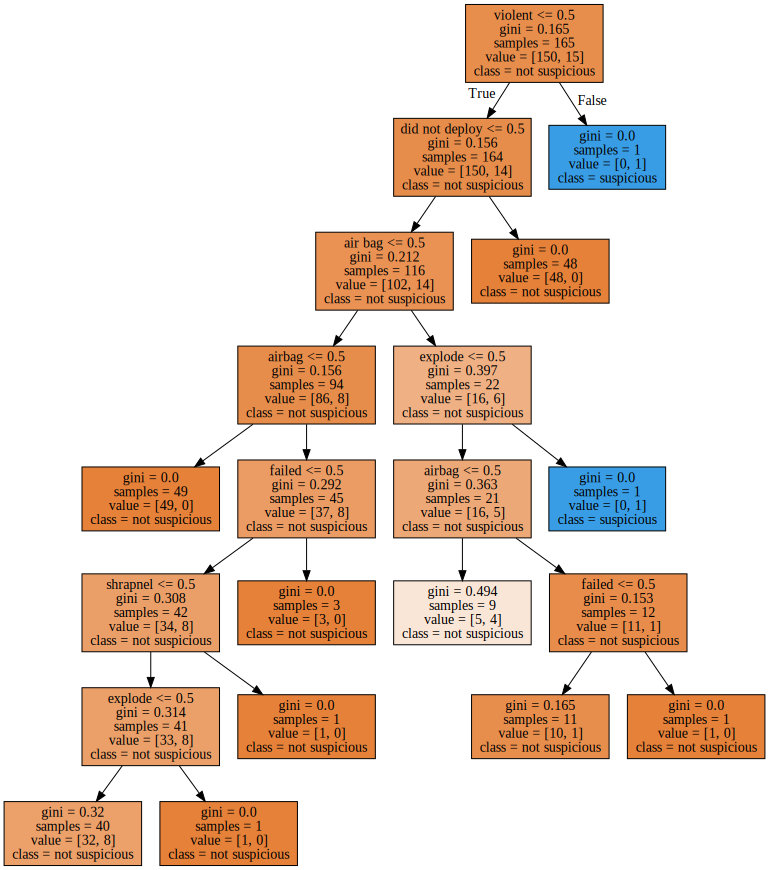

In [13]:
from sklearn import tree
import graphviz

label_names = ['not suspicious', 'suspicious']
feature_names = X.columns

dot_data = tree.export_graphviz(clf,
                    feature_names=feature_names,  
                    filled=True,
                    class_names=label_names)  
graph = graphviz.Source(dot_data)  
graph

You can also also see the tree with `eli5`, I just suppressed it because I thought we could use a little color.

In [15]:
feature_names = list(X.columns)

eli5.show_weights(clf,
                  feature_names=feature_names,
                  target_names=label_names)

Weight,Feature
0.3440,airbag
0.2026,violent
0.1529,air bag
0.1445,explode
0.1205,did not deploy
0.0266,failed
0.0091,shrapnel


And the best part is: almost everything you can do with a logistic regression classifier you can do with a decision tree. Most of the time you can just **change your classifier to see if it does better.**

Decision trees also have a lot of simple options.

In [16]:
from sklearn.tree import DecisionTreeClassifier

X = train_df.drop(columns='is_suspicious')
y = train_df.is_suspicious

clf = DecisionTreeClassifier(max_depth=2)

clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

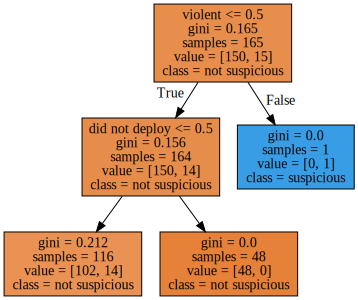

In [17]:
from sklearn import tree
import graphviz

label_names = ['not suspicious', 'suspicious']
feature_names = X.columns

dot_data = tree.export_graphviz(clf,
                    feature_names=feature_names,  
                    filled=True,
                    class_names=label_names)  
graph = graphviz.Source(dot_data)  
graph

### A random forest is usually even better

Although in this case our inputs are terrible so it's still not very good. Garbage in, garbage out.

We'l change our classifier to be

```python
clf = RandomForestClassifier(n_estimators=100)
```

and it will use 100 decision **trees** to make a **forest**.

In [18]:
from sklearn.ensemble import RandomForestClassifier

X = train_df.drop(columns='is_suspicious')
y = train_df.is_suspicious

clf = RandomForestClassifier(n_estimators=100)

clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
from sklearn.metrics import confusion_matrix

y_true = y
y_pred = clf.predict(X)

matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['not suspicious', 'suspicious'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names)

,Predicted not suspicious,Predicted suspicious
Is not suspicious,150,0
Is suspicious,13,2


In [20]:
feature_names = list(X.columns)

eli5.show_weights(clf, feature_names=feature_names, show=eli5.formatters.fields.ALL)

Weight,Feature
0.2394 ± 0.3216,did not deploy
0.2223 ± 0.3465,airbag
0.2101 ± 0.4087,air bag
0.1543 ± 0.2972,violent
0.1314 ± 0.2854,explode
0.0369 ± 0.0527,failed
0.0057 ± 0.0190,shrapnel


## Review

In our previous two attempts to tackle Takata airbag investigation, we used a **logistic regression classifier**. This time we're trying a new type called a **random forest**, which performed _slightly_ better (although it could have just been chance).

Despite this slight improvement, its predictions were still very off.

## Discussion topics

What's wrong here? Why does nothing work for us, even though we keep throwing more machine learning tools at it?